<a href="https://colab.research.google.com/github/machiwao/CCMACLRL_PROJECT_COM222/blob/main/project_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis of Shopee Computer Product Reviews

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import seaborn as sns
import re
import os, types
import requests

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from nltk import FreqDist
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from scipy.sparse import hstack

nltk.download("punkt")
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Blix\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Blix\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Blix\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Data Loading

In [ ]:
df = pd.read_csv("hf://datasets/magixxixx/shopee-product-reviews-on-computer-category/combined-dataset-shuffled-cased-40K.csv")

In [ ]:
df.head()

,text,sentiment
0,mali yung dineliver 2l order ko naging 1l bulok!,0
1,xl order ko dumating large.nkalagay sa sticker...,0
2,"sobrang bilis ma lowbat, hindi masyado nakaka ...",0
3,first time ko umorder dito. di naman gumagana ...,0
4,"not well packed, wala itong box. hindi sya ma ...",0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       40000 non-null  object
 1   sentiment  40000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 625.1+ KB


In [ ]:
df.isnull().sum()

text         0
sentiment    0
dtype: int64

In [ ]:
df.duplicated().sum()

np.int64(1)

In [ ]:
df['sentiment'].value_counts()

sentiment
0    20000
1    20000
Name: count, dtype: int64

## Data Preprocessing

In [ ]:
df.drop_duplicates(inplace = True)

In [ ]:
def get_stopwords(url):
    response = requests.get(url)
    response.encoding = 'utf-8' # Ensure proper encoding for Filipino text
    stopwords_list = response.text.splitlines()
    return stopwords_list

# Load Filipino stop words
combined_stopwords = set(stopwords.words('english')) | set(get_stopwords("https://raw.githubusercontent.com/stopwords-iso/stopwords-tl/master/raw/genediazjr-tagalog.txt"))

In [ ]:
bad_words = ["amputa","animal ka","bilat","binibrocha","bobo","bogo","boto",
             "brocha","burat","bwesit","bwisit","demonyo ka","engot","etits",
             "gaga","gagi","gago","habal","hayop ka","hayup","hinampak",
             "hinayupak","hindot","hindutan","hudas","iniyot","inutel","inutil",
             "iyot","kagaguhan","kagang","kantot","kantotan","kantut","kantutan",
             "kaululan","kayat","kiki","kikinginamo","kingina","kupal","leche",
             "leching","lechugas","lintik","nakakaburat","nimal","ogag","olok",
             "pakingshet","pakshet","pakyu","pesteng yawa","poke","poki",
             "pokpok","poyet","pu'keng","pucha","puchanggala","puchangina",
             "puke","puki","pukinangina","puking","punyeta","puta","putang",
             "putang ina","putangina","putanginamo","putaragis","putragis",
             "puyet","ratbu","shunga","sira ulo","siraulo","suso","susu","tae",
             "taena","tamod","tanga","tangina","taragis","tarantado","tete",
             "teti","timang","tinil","tite","titi","tungaw","ulol","ulul",
             "ungas", "yawa"]

bad_words_pattern = re.compile(r'\b(' + '|'.join([re.escape(word) for word in bad_words]) + r')\b', re.IGNORECASE)

In [ ]:
def preprocess_text(text):
  # Convert to lowercase
  text = text.lower()
  text = bad_words_pattern.sub('[PROFANITY]', text)
  # remove_digits_urls_special_chars
  text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
  text = re.sub(r'[^a-zA-Z]', ' ', text) # Remove non-alphabetic characters
  text = re.sub(r'\b(\w+)\1+\b', r'\1', text)  # Reduce repeated words to root word
  text = re.sub(r'\@\w+|\#', '', text)
  text = re.sub(r'[^\w\s]', '', text)
  text = text.strip()
  text = re.sub(r'\s+', ' ', text).strip()
  text = re.sub(r'\s+$', '', text)
  text = re.sub(r'\d+', '', text)


  text = ' '.join([word for word in text.split() if word not in combined_stopwords])

  # Lemmatization
  lemmatizer = WordNetLemmatizer()
  text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

  return text

In [ ]:
def reduce_repeating_letters(word):
    if not word:
        return ""

    reduced_word = [word[0]]  # Start with the first character
    for char in word[1:]:
        if char != reduced_word[-1]:  # Compare with the last added character
            reduced_word.append(char)

    return ''.join(reduced_word)

In [ ]:
df['text'] = df['text'].apply(reduce_repeating_letters)
df['text'] = df['text'].apply(preprocess_text)

## Training the Model

In [ ]:
X = df['text']
y = df['sentiment']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
combined_stopwords_list = list(combined_stopwords)
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_df=0.9, min_df=5, stop_words=combined_stopwords_list)
X_train_transformed = vectorizer.fit_transform(X_train)
X_test_transformed = vectorizer.transform(X_test)

## Training Baseline Models

In [92]:
models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(),
    "SVM": SVC(kernel='linear')
}

In [93]:
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test):
    # Train the model
    model.fit(X_train, y_train)
    # Predict on test data
    y_pred = model.predict(X_test)
    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    return accuracy, report

In [94]:
for model_name, model in models.items():
    accuracy, report = train_and_evaluate_model(model, X_train_transformed, y_train, X_test_transformed, y_test)
    print(f"{model_name}:\nAccuracy: {accuracy}\nReport:\n{report}\n")

Naive Bayes:
Accuracy: 0.96125
Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.96      3968
           1       0.98      0.95      0.96      4032

    accuracy                           0.96      8000
   macro avg       0.96      0.96      0.96      8000
weighted avg       0.96      0.96      0.96      8000


Logistic Regression:
Accuracy: 0.96575
Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      3968
           1       0.97      0.96      0.97      4032

    accuracy                           0.97      8000
   macro avg       0.97      0.97      0.97      8000
weighted avg       0.97      0.97      0.97      8000


SVM:
Accuracy: 0.9705
Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      3968
           1       0.97      0.97      0.97      4032

    accuracy                           0.97      8000
   macro a

In [ ]:
from sklearn.svm import SVC

model = SVC()

### Hyperparameter Tuning and Cross Validation

In [ ]:
param_grid = {
    'C': [0.1, 1, 5, 10, 100],
    'kernel': ['linear'],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001, 'scale','auto']
}

In [ ]:
grid = GridSearchCV(model, param_grid, refit=True, cv=5, n_jobs= -1, return_train_score=True, verbose=0)

# Train with grid search
grid.fit(X_train_transformed, y_train)

# Access cv_results_ to extract scores
cv_results = grid.cv_results_

# Iterate over all combinations of parameters
for i in range(len(cv_results['params'])):
    print(f"Iteration {i+1}:")
    print(f"Parameters: {cv_results['params'][i]}")

    # Train accuracy for this iteration
    train_acc = cv_results['mean_train_score'][i]
    print(f"Train Accuracy: {train_acc:.4f}")

    # Test accuracy for this iteration (mean cross-validated test score)
    test_acc = cv_results['mean_test_score'][i]
    print(f"Test Accuracy: {test_acc:.4f}")
    print('-' * 50)

Iteration 1:
Parameters: {'C': 0.1, 'gamma': 1, 'kernel': 'linear'}
Train Accuracy: 0.9662
Test Accuracy: 0.9592
--------------------------------------------------
Iteration 2:
Parameters: {'C': 0.1, 'gamma': 0.1, 'kernel': 'linear'}
Train Accuracy: 0.9662
Test Accuracy: 0.9592
--------------------------------------------------
Iteration 3:
Parameters: {'C': 0.1, 'gamma': 0.01, 'kernel': 'linear'}
Train Accuracy: 0.9662
Test Accuracy: 0.9592
--------------------------------------------------
Iteration 4:
Parameters: {'C': 0.1, 'gamma': 0.001, 'kernel': 'linear'}
Train Accuracy: 0.9662
Test Accuracy: 0.9592
--------------------------------------------------
Iteration 5:
Parameters: {'C': 0.1, 'gamma': 0.0001, 'kernel': 'linear'}
Train Accuracy: 0.9662
Test Accuracy: 0.9592
--------------------------------------------------
Iteration 6:
Parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Train Accuracy: 0.9662
Test Accuracy: 0.9592
-----------------------------------------------

In [ ]:
# Best parameters
print("Best Parameters: ", grid.best_params_)
print("Best Estimator: ", grid.best_estimator_)

Best Parameters:  {'C': 1, 'gamma': 1, 'kernel': 'linear'}
Best Estimator:  SVC(C=1, gamma=1, kernel='linear')


In [ ]:
# Chosen Model
model = SVC(C = 1, gamma = 1, kernel = 'linear')
model.fit(X_train_transformed, y_train)

SVC(C=1, gamma=1, kernel='linear')

In [ ]:
# Cross Validation
X_transformed = vectorizer.transform(X)
cv_scores = cross_val_score(model, X_transformed, y, cv=5)
print(cv_scores)
print(cv_scores.mean())
print(cv_scores.std())

[0.97       0.968625   0.966875   0.97225    0.96787098]
0.9691241967745968
0.0018663495503768966


## Model Testing

In [91]:
print(X_train.info)

<bound method Series.info of 5485     maganda quality talaga makapal mukang matibay ...
14857    tagal dumating photo video related nmn sakin y...
6897     sobrang legit product naka pack sya mayo mabil...
17912    okey nman bat ganun box naman pala ung sapatos...
19125    di kopa nga nasuot nasira nalaglag agad yung b...
                               ...                        
6265     god god god bilis seler mag ship bilis shope e...
11284    th logi wireles mouse love bought gift recipie...
38159    responsible seler product actualy complete may...
860      maganda always world magpackage defect fuly tr...
15796    sampung inorder kalawang basa dumating tapos m...
Name: text, Length: 31999, dtype: object>


In [ ]:
y_pred = model.predict(X_test_transformed)
final_test_acc = accuracy_score(y_test, y_pred)
print(f"\nFinal Test Accuracy of Best Model: {final_test_acc:.4f}")


Final Test Accuracy of Best Model: 0.9706


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      3968
           1       0.97      0.97      0.97      4032

    accuracy                           0.97      8000
   macro avg       0.97      0.97      0.97      8000
weighted avg       0.97      0.97      0.97      8000



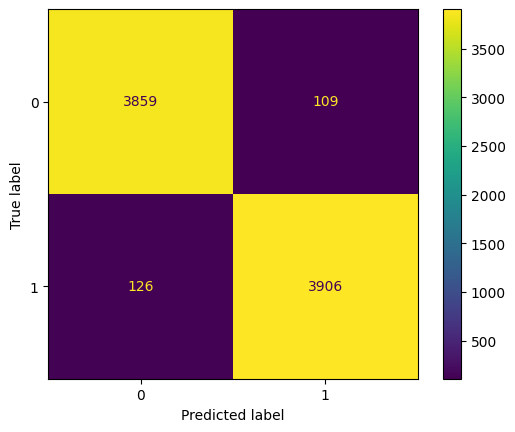

In [ ]:
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

In [ ]:
input_texts = ['This shit is so damn good product',
               'Hindi niyo ako maloloko! Original to noh? Ang ganda!',
               'Tangina good shit!', 'Tagal niya dumating pero ang solid hahaha',
               'Ito na yon? Hindi man lang tumagal.', 'Anggggg gandaaaaaa.',
               'Ayos gumana! natest ko na din sa OS no issues so far, will update if there will be, sana tumagal. dito na kayo bumili maayos kausap si seller tska responsive. order ako ulet SSDs naman.',
               'Nagorder ak intel heatsink fan daw. pero hindi intel dumating. scam.',
               'Sira yung isang pin buti nalang may available ako na pin sa luma ko ayun nalang ginamit kong pin',
               'Good legit seller. Maayos kausap at good quality. Sobrang ganda at ma ayos ang pag ka balot sa item. Uulit ulit ako nag order dito sa shop nya .',
               'd ako binigo ni it world , solid as usual , naka discount pa dahil sa vouchers ! good na good :D',
               'normal lng ba to? patukin Muna pra gumana?',
               'sakto lng..dko sure kung nbagsak kasi may dent s kanto ng unit..ewan kung si seller o si jnt',
               'Now lang nagreview kasi gusto ko muna sya itry..so far sa ilang days na gamit ko sya di nman ako binigo..sana mas magtagal pa..legit may kasama ding extra fuse.',
               "good except the BIOS. It's not graphical and very basic AMI BIOS.",
               "Dalawang USB port lang gumagana, mouse keyboard lang nasaksak ko, Yung apat na USB port di gumagana, sad tyaka Yung power Buti nagamit pa, pero Yung pang restart at LED, ayaw",
               "Works just fine at first. Pero bigla nalng sumabog. Yikes"
               "Dalawa binili ko. Yung isa pag open na pag open palang yupi. Awit eh..",
               "gumagana naman. may dent yung kanto at naka angat yung likod.",
               "Kung sino man nagbabasa neto, bilhin mo nato. LF kasama sa scam"
               ]

In [ ]:
for text in input_texts:
  input_text = pd.Series(text)
  input_text = input_text.apply(reduce_repeating_letters)
  input_text = input_text.apply(preprocess_text)
  input_text_transform = vectorizer.transform(input_text)
  prediction = model.predict(input_text_transform)
  if prediction == 0:
    print(f"Review: {text} -> Sentiment: Bad")
  else:
    print(f"Review: {text} -> Sentiment: Good")

Review: This shit is so damn good product -> Sentiment: Good
Review: Hindi niyo ako maloloko! Original to noh? Ang ganda! -> Sentiment: Good
Review: Tangina good shit! -> Sentiment: Good
Review: Tagal niya dumating pero ang solid hahaha -> Sentiment: Good
Review: Ito na yon? Hindi man lang tumagal. -> Sentiment: Bad
Review: Anggggg gandaaaaaa. -> Sentiment: Good
Review: Ayos gumana! natest ko na din sa OS no issues so far, will update if there will be, sana tumagal. dito na kayo bumili maayos kausap si seller tska responsive. order ako ulet SSDs naman. -> Sentiment: Good
Review: Nagorder ak intel heatsink fan daw. pero hindi intel dumating. scam. -> Sentiment: Good
Review: Sira yung isang pin buti nalang may available ako na pin sa luma ko ayun nalang ginamit kong pin -> Sentiment: Bad
Review: Good legit seller. Maayos kausap at good quality. Sobrang ganda at ma ayos ang pag ka balot sa item. Uulit ulit ako nag order dito sa shop nya . -> Sentiment: Good
Review: d ako binigo ni it worl